# NDVI Anomaly adapted from https://github.com/ceos-seo/data_cube_notebooks
This notebook compares NDVI between two time periods to detect land change. In the case of deforestation, the NDVI values will reduce from (0.6 to 0.9 ... typical for forests) to lower values (<0.6). This change can be detected and used to investigate deforestation or monitor the extent of the land change.

In [2]:
name = "NDVI anomaly"
version = 0.01

import sys
sys.path.append('/home/jovyan/odc-hub/')

# Choose Platform and Product

In [3]:
import warnings
# Supress Warning 
warnings.filterwarnings('ignore')

In [4]:
import utils_dcal.data_cube_utilities.data_access_api as dc_api  
api = dc_api.DataAccessApi()
#dc = api.dc
import datacube
dc = datacube.Datacube(app='ndvi anomoly')

In [5]:
# Get available products
products_info = dc.list_products()

In [6]:
# List LANDSAT 7 products
print("LANDSAT 7 Products:")
products_info[["platform", "name"]][products_info.platform == "LANDSAT_7"]

LANDSAT 7 Products:


,platform,name
id,,
4,LANDSAT_7,ls7_usgs_sr_scene


In [7]:
# List LANDSAT 8 products
print("LANDSAT 8 Products:")
products_info[["platform", "name"]][products_info.platform == "LANDSAT_8"]

LANDSAT 8 Products:


,platform,name
id,,
6,LANDSAT_8,ls8_usgs_fc_scene
3,LANDSAT_8,ls8_usgs_sr_scene


In [8]:
# Select one of the data cubes

product = "ls8_usgs_sr_scene"
platform = "LANDSAT_8" 
crs = "EPSG:32760"
resolution = (-30, 30)

# product = "ls8_lasrc_tanzania"
# platform = "LANDSAT_8" 

In [9]:
# # Get product extents
# prod_extents = api.get_query_metadata(platform=platform, product=product, measurements=[])

# latitude_extents = prod_extents['lat_extents']
# print("Lat bounds:", latitude_extents)
# longitude_extents = prod_extents['lon_extents']
# print("Lon bounds:", longitude_extents)
# time_extents = list(map(lambda time: time.strftime('%Y-%m-%d'), prod_extents['time_extents']))
# print("Time bounds:", time_extents)

In [10]:
from utils_dcal.data_cube_utilities.dc_load import get_product_extents
from utils_dcal.data_cube_utilities.dc_time import dt_to_str

full_lat, full_lon, min_max_dates = get_product_extents(api, platform, product, output_crs = crs, resolution = resolution)

# Print the extents of the combined data.
print("Latitude Extents:", full_lat)
print("Longitude Extents:", full_lon)
print("Time Extents:", list(map(dt_to_str, min_max_dates)))

Latitude Extents: (-9944280.0, 28434030.0)
Longitude Extents: (-3734250.0, 12036510.0)
Time Extents: ['2013-03-21', '2019-04-10']


In [11]:
# Select an analysis region and visualize the region

# Aviv Coffee Farm
# latitude = (-10.75, -10.68) 
# longitude = (35.22, 35.28) 

# Dodoma, Tanzania
#longitude = (177.48, 177.85)
#latitude = (-18.00, -18.37)

latitude = -18.00
longitude = 177.481
buffer = 0.045

latitude = (latitude+buffer, latitude-buffer)
longitude = (longitude-buffer, longitude+buffer)

# 'x': (longitude-buffer, longitude+buffer),
 #   'y': (latitude+buffer, latitude-buffer),
#latitude = (-6.27, -6.04) 
#longitude = (35.66, 35.89)

In [12]:
print(latitude)
print(longitude)

(-17.955, -18.045)
(177.436, 177.52599999999998)


In [13]:
## The code below renders a map that can be used to orient yourself with the region.
from utils_dcal.data_cube_utilities.dc_display_map import display_map
#from deaAfricascripts.deafrica_plotting import display_map
display_map(latitude = latitude, longitude = longitude)
#display_map(x=(longitude-buffer, longitude+buffer), y=(latitude+buffer, latitude-buffer))

# Define Analysis Parameters 

In [14]:
from datetime import datetime

In [15]:
# To compare the NDVI values from two time periods (baseline and analysis), 
# it is best to create "Maximum NDVI" cloud-free mosaics and then compare the changes

# Select the baseline time period (start and end)
baseline_time_period = (datetime(2014,1,1), datetime(2014,12,31))

# Select the analysis time period (start and end)
analysis_time_period = (datetime(2015,1,1), datetime(2015,12,31)) 

# Select the cloud-free mosaic type
# Options are: max_ndvi, median, most_recent_pixel
# It is most common to use the maximum NDVI mosaic for this analysis

baseline_mosaic_function = "max_ndvi" 
analysis_mosaic_function = "max_ndvi" 

# Select a baseline NDVI threshold range
# The analysis will only consider pixels in this range for change detection
# Example: use 0.6 to 0.9 for dense vegetation, grasslands are 0.2 to 0.6
ndvi_baseline_threshold_range = (0.6, 0.9)  

# Load and Clean Data

>####  Initialize Connection to Datacube

In [16]:
#import datacube
#dc = datacube.Datacube(app = "{name}_v{versioning}".format(name = name, versioning = version))

>#### Load Data ( Baseline, Analysis) 

In [17]:
baseline_ds = dc.load(
    latitude = latitude,
    longitude = longitude,
    time = baseline_time_period,
    measurements = ["red", "green", "blue", "nir", "swir1", "swir2", "pixel_qa"],
    product = product,
    platform = platform,
    output_crs = crs,
    resolution = resolution
)


In [18]:
analysis_ds = dc.load(
    latitude = latitude,
    longitude = longitude,
    time = analysis_time_period,
    measurements = ["red", "green", "blue", "nir", "swir1", "swir2", "pixel_qa"],
    product = product,
    platform = platform,
    output_crs = crs,
    resolution = resolution
)

> #### Check if loads are valid

In [19]:
import xarray as xr 
def is_dataset_empty(ds:xr.Dataset) -> bool:
    checks_for_empty = [
                        lambda x: len(x.dims) == 0,      #Dataset has no dimensions
                        lambda x: len(x.data_vars) == 0  #Dataset no variables 
                       ]
    for f in checks_for_empty:
         if f(ds) == True:
                return True
    return False

In [20]:
if is_dataset_empty(baseline_ds): raise Exception("DataCube Load returned an empty Dataset." +  
                                               "Please check load parameters for Baseline Dataset!")

In [21]:
if is_dataset_empty(analysis_ds): raise Exception("DataCube Load returned an empty Dataset." +  
                                               "Please check load parameters for Analysis Dataset!")

> #### Clean Data
> Generating boolean masks that highlight valid pixels
> Pixels must be cloud-free over land or water to be considered

In [22]:
from utils_dcal.data_cube_utilities.dc_mosaic import ls8_unpack_qa, ls7_unpack_qa 

unpack_function = {"LANDSAT_7": ls7_unpack_qa,
                   "LANDSAT_8": ls8_unpack_qa}

unpack = unpack_function[platform]

In [23]:
import numpy as np
def clean_mask(ds, unpacking_func, bands):
    masks = [unpacking_func(ds, band) for band in bands]
    return np.logical_or(*masks).values

In [24]:
baseline_clean_mask = clean_mask(baseline_ds.pixel_qa,unpack, ["clear", "water"])
analysis_clean_mask = clean_mask(analysis_ds.pixel_qa, unpack, ["clear", "water"])

In [25]:
baseline_ds = baseline_ds.where(baseline_clean_mask)
analysis_ds = analysis_ds.where(analysis_clean_mask)

>#### Mosaic
> Use clean masks in a time series composite

In [26]:
from utils_dcal.data_cube_utilities.dc_mosaic import create_max_ndvi_mosaic, create_median_mosaic, create_mosaic

In [27]:
mosaic_function = {"median": create_median_mosaic,
                   "max_ndvi": create_max_ndvi_mosaic,
                   "most_recent_pixel": create_mosaic}

In [28]:
baseline_compositor = mosaic_function[baseline_mosaic_function]
analysis_compositor = mosaic_function[analysis_mosaic_function]

In [29]:
baseline_composite = baseline_compositor(baseline_ds, clean_mask = baseline_clean_mask)
analysis_composite = analysis_compositor(analysis_ds, clean_mask = analysis_clean_mask)

In [30]:
from utils_dcal.data_cube_utilities.dc_rgb import rgb

(<Figure size 720x691.892 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fa3aefeb240>)

<Figure size 864x432 with 0 Axes>

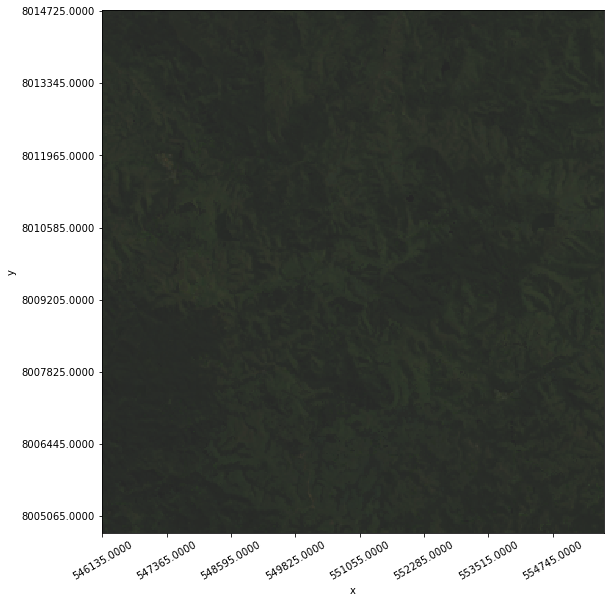

In [31]:
import matplotlib.pyplot as plt
plt.figure(figsize = (12,6))
rgb(baseline_composite, x_coord='x', y_coord='y')

(<Figure size 720x691.892 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fa3aee3cb38>)

<Figure size 864x432 with 0 Axes>

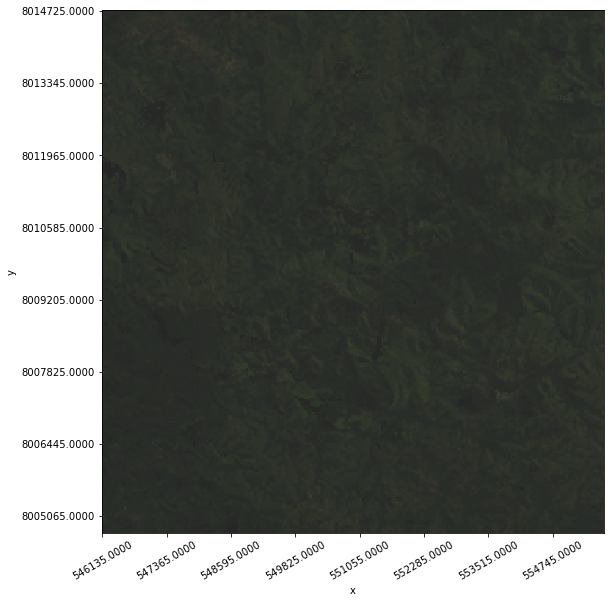

In [32]:
plt.figure(figsize = (12,6))
rgb(analysis_composite, x_coord='x', y_coord='y')

>#### Baseline Mosaic using the NDVI Threshold Range
The image below will mask clouds and only include pixels that fall within the threshold range

In [33]:
def NDVI(dataset):
    return (dataset.nir - dataset.red)/(dataset.nir + dataset.red)

In [34]:
def TCAPWET(dataset):
        return (0.1509*dataset.red + 0.1973*dataset.green + 0.3279*dataset.blue 
                + 0.3406*dataset.nir - 0.7112*dataset.swir1 - 0.4572*dataset.swir2)

In [35]:
_min, _max = ndvi_baseline_threshold_range  
baseline_ndvi_filter_mask = np.logical_and(NDVI(baseline_composite) > _min, NDVI(baseline_composite) < _max)    

In [36]:
def aspect_ratio_helper(ds, fixed_width = 15):
        y,x = ds.values.shape
        width = fixed_width
        height = y * (fixed_width / x)
        return (width, height)

In [37]:
import matplotlib.pyplot as plt
from matplotlib.cm import RdYlGn, Greens
RdYlGn.set_bad('black',1.)
Greens.set_bad('black',1.)

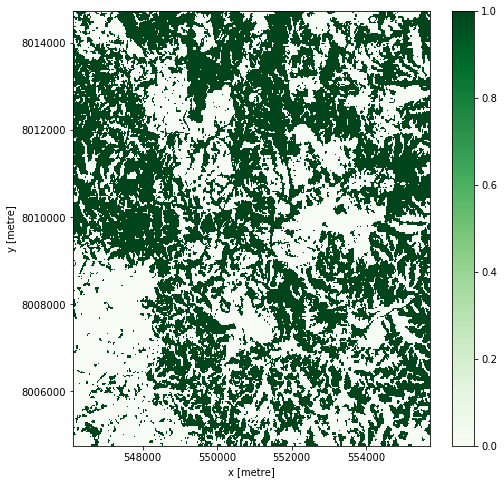

In [38]:
# This is the baseline NDVI threshold plot that shows GREEN pixels in the threshold range
# plt.figure(figsize = aspect_ratio_helper(baseline_ndvi_filter_mask)) 
plt.figure(figsize = (8,8))
baseline_ndvi_filter_mask.plot(cmap = "Greens")

In [39]:
baseline_composite = baseline_composite.where(baseline_ndvi_filter_mask)

# Wetness Anomaly

In [40]:
tcap_wet_baseline = TCAPWET(baseline_composite) # Tasselled Cap Wetness

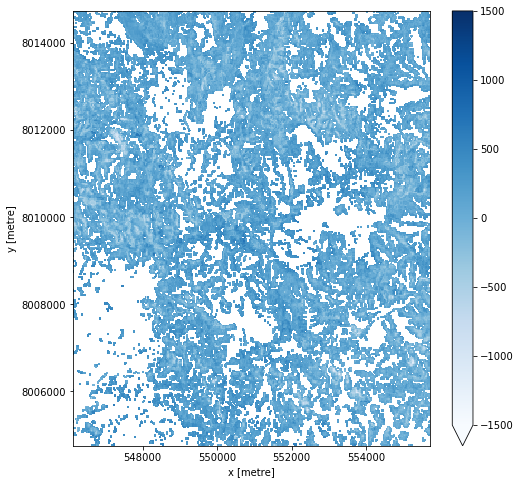

In [41]:
(tcap_wet_baseline).plot(figsize=(8,8), vmin=-1500, vmax=1500, cmap = "Blues")

In [42]:
analysis_composite_mask = analysis_composite.where(baseline_ndvi_filter_mask)

In [43]:
tcap_wet_analysis = TCAPWET(analysis_composite_mask) # Tasselled Cap Wetness

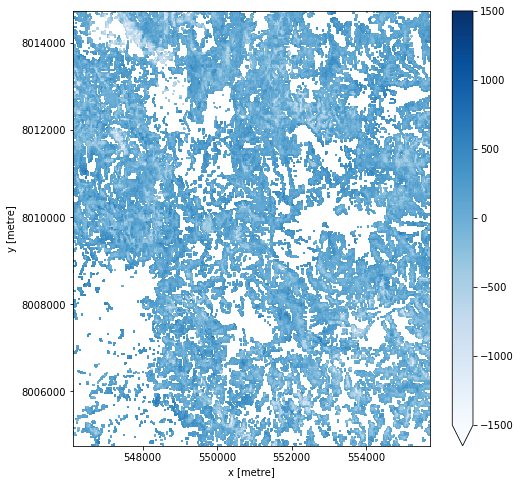

In [44]:
(tcap_wet_analysis).plot(figsize=(8,8), vmin=-1500, vmax=1500, cmap = "Blues")

In [45]:
wetness_anomaly = tcap_wet_analysis - tcap_wet_baseline

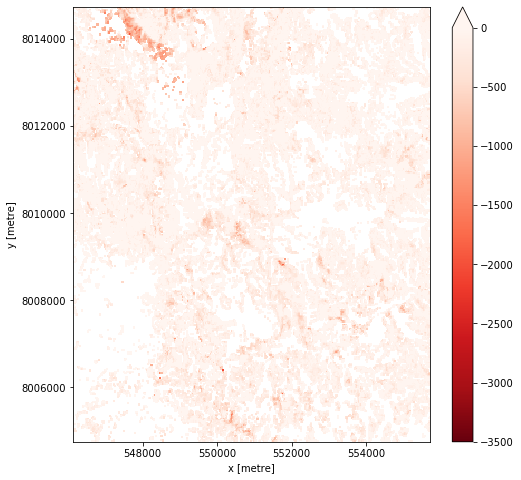

In [46]:
(wetness_anomaly).plot(figsize=(8,8), vmin=-3500, vmax=0, cmap = "Reds_r")

# NDVI Anomaly

In [47]:
ndvi_baseline_composite = NDVI(baseline_composite)
ndvi_analysis_composite = NDVI(analysis_composite)

In [48]:
ndvi_anomaly = ndvi_analysis_composite - ndvi_baseline_composite

>#### NDVI Anomaly Plot


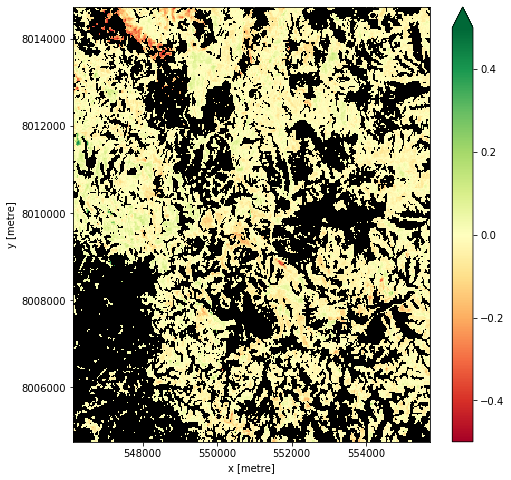

In [49]:
# plt.figure(figsize = aspect_ratio_helper(ndvi_anomaly))
plt.figure(figsize = (8,8))
ndvi_anomaly.plot(vmin=-0.5, vmax=0.5, cmap = RdYlGn)

>#### Discretized/Binned plot

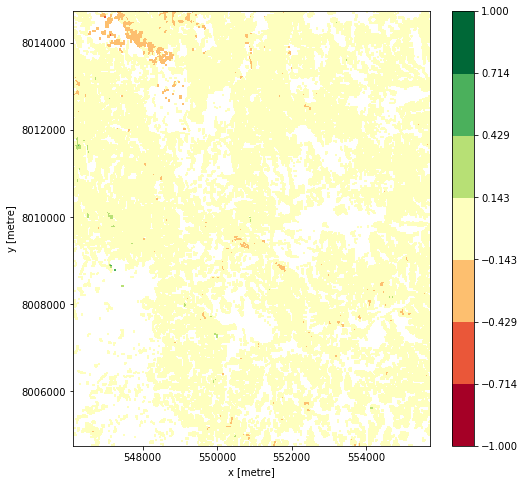

In [50]:
#plt.figure(figsize = aspect_ratio_helper(ndvi_anomaly)) 
plt.figure(figsize = (8,8))
ndvi_anomaly.plot(levels = 8, vmin=-1, vmax=1, cmap = RdYlGn)

In [51]:
# from dc_notebook_utilities import create_discrete_color_map
from utils_dcal.data_cube_utilities.plotter_utils import create_discrete_color_map
cmap = create_discrete_color_map(data_range=(-1,1), 
                                 th=[0.0], colors=[(240,93,94), (126,243,125)])
cmap.set_bad("black", 1.)

>#### NDVI Anomaly

This product shows the following ...<br>
BLACK = Cloud or Pixels NOT in the baseline threshold range<br>
GREEN = Pixels with an increase in NDVI<br>
RED = Pixels with a decrease in NDVI<br>

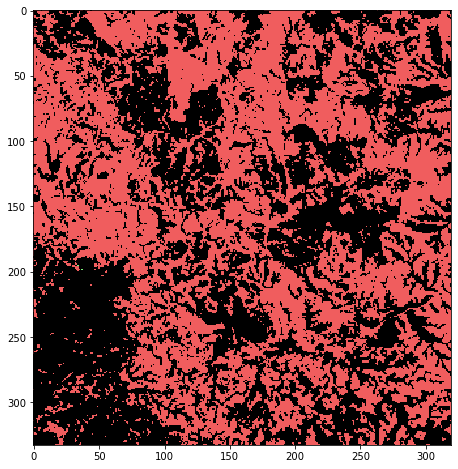

In [52]:
# plt.figure(figsize = aspect_ratio_helper(ndvi_anomaly)) 
plt.figure(figsize = (8,8))
plt.imshow(ndvi_anomaly.values, cmap=cmap, vmin=-1, vmax=1)
plt.show()

# NDVI Anomaly Threshold Product

In [53]:
# Select NDVI Anomaly Threshold Range
# We are looking for pixels that have lost significant vegetation
# NDVI losses are typically 0.1 or more for deforestation

minimum_change = -0.6
maximum_change = -0.2

>#### NDVI Change Distribution
Threshold range, highlighted in red

In [64]:
from matplotlib.ticker import FuncFormatter

def threshold_plot(da, min_threshold, max_threshold, mask = None, width = 10, *args, **kwargs): 
    color_in    = np.array([255,0,0])
    color_out   = np.array([0,0,0])
    color_cloud = np.array([255,255,255])
    
    array = np.zeros((*da.values.shape, 3)).astype(np.int16)
    
    inside  = np.logical_and(da.values > min_threshold, da.values < max_threshold)
    outside = np.invert(inside)
    masked  = np.zeros(da.values.shape).astype(bool) if mask is None else mask
    
    array[inside] =  color_in
    array[outside] = color_out
    array[masked] =  color_cloud

    def figure_ratio(ds, fixed_width = 10):
        width = fixed_width
        height = len(ds.y) * (fixed_width / len(ds.x))
        return (width, height)


    fig, ax = plt.subplots(figsize = figure_ratio(da,fixed_width = width))
    
    lat_formatter = FuncFormatter(lambda y_val, tick_pos: "{0:.3f}".format(da.y.values[tick_pos] ))
    lon_formatter = FuncFormatter(lambda x_val, tick_pos: "{0:.3f}".format(da.x.values[tick_pos]))

    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    
    plt.title("Threshold: {} < x < {}".format(min_threshold, max_threshold))
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    
    plt.imshow(array, *args, **kwargs)
    plt.show()

In [65]:
no_data_mask = np.logical_or(np.isnan(baseline_composite.red.values), np.isnan(analysis_composite.red.values)) 

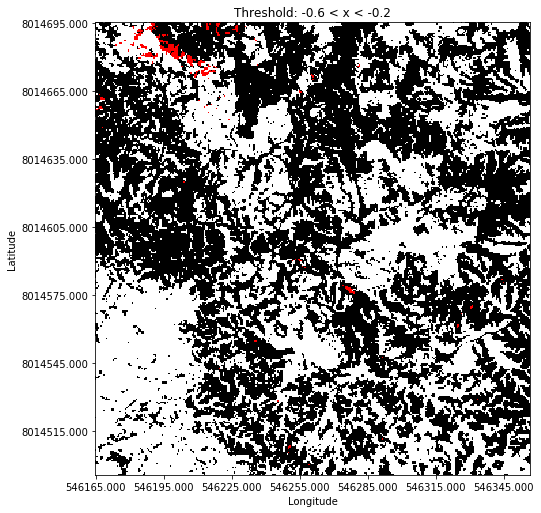

In [66]:
threshold_plot(ndvi_anomaly, minimum_change, maximum_change, mask = no_data_mask, width  = 8)

In [57]:
def threshold_count(da, min_threshold, max_threshold, mask = None):
    def count_not_nans(arr):
        return np.count_nonzero(~np.isnan(arr))
    
    in_threshold = np.logical_and( da.values > min_threshold, da.values < max_threshold)
    
    total_non_cloudy = count_not_nans(da.values) if mask is None else np.sum(mask) 
    
    return dict(total = np.size(da.values),
                total_non_cloudy = total_non_cloudy,
                inside = np.nansum(in_threshold),
                outside = total_non_cloudy - np.nansum(in_threshold)
               )    
    
def threshold_percentage(da, min_threshold, max_threshold, mask = None):
    counts = threshold_count(da, min_threshold, max_threshold, mask = mask)
    return dict(percent_inside_threshold = (counts["inside"]   / counts["total"]) * 100.0,
                percent_outside_threshold = (counts["outside"] / counts["total"]) * 100.0,
                percent_clouds = ( 100.0-counts["total_non_cloudy"] / counts["total"] * 100.0))


In [58]:
threshold_count(ndvi_anomaly,minimum_change,maximum_change)

{'total': 106560, 'total_non_cloudy': 56447, 'inside': 460, 'outside': 55987}

In [60]:
threshold_percentage(ndvi_anomaly,minimum_change,maximum_change)

{'percent_inside_threshold': 0.43168168168168164,
 'percent_outside_threshold': 52.540352852852855,
 'percent_clouds': 47.027965465465456}